<a href="https://colab.research.google.com/github/dcdc-png/CVNLP/blob/main/Plant_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Data and Show Sample Code

['Tomato___Early_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']

Total number of selected classes are:  3

The number of images in Tomato___Early_blight:  1920 
The number of images in Tomato___Tomato_Yellow_Leaf_Curl_Virus:  1961 
The number of images in Tomato___healthy:  1926 
The total images inside the directory:  5807 



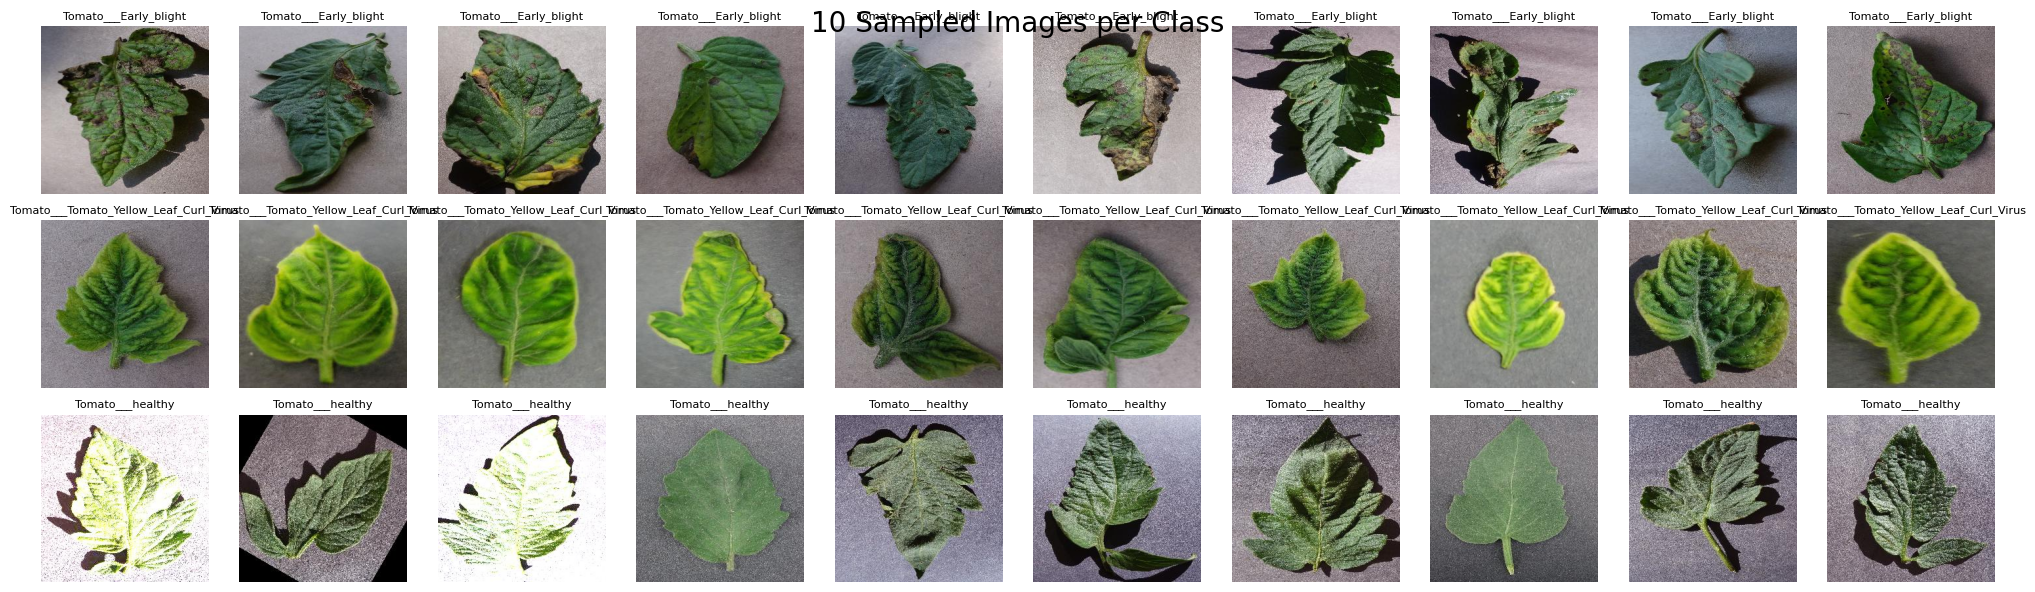

In [ ]:
!pip install colorama
!pip install kagglehub
!pip install split-folders
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import random
import matplotlib.pyplot as plt
from colorama import Fore
import kagglehub
import sys
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import splitfolders

Root_dir = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

# Define the training and validation directories based on the provided full path
train_dir = os.path.join(Root_dir, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "train")
valid_dir = os.path.join(Root_dir, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "valid")
test_dir = "temp_test_dir"

# Define the specific classes to include
Diseases_classes = ["Tomato___Early_blight", "Tomato___Tomato_Yellow_Leaf_Curl_Virus", "Tomato___healthy"]

print(Fore.GREEN + str(Diseases_classes))
print("\nTotal number of selected classes are: ", len(Diseases_classes))

# Set the number of images to display per class
subset_size = 10
cols = 10  # Number of columns for each class grid
rows = len(Diseases_classes)  # Rows per class

# Create a figure to hold all images from each class
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2), dpi=100) # Creates a space for the image to be displayed, and adjust the size and quality of image

# Loop through each class and plot 10 images in a grid
tot_images = 0
for class_idx, class_name in enumerate(Diseases_classes):
    image_files = os.listdir(train_dir + "/" + class_name) # Loops through each directory
    sampled_files = random.sample(image_files, min(subset_size, len(image_files)))  # Randomly sample 10 images of each directory, scan through the total number of images in each files
    print("\nThe number of images in " + class_name + ": " , len(image_files), end=" ")
    tot_images += len(image_files)

    # Display each image with labels
    for i, img_file in enumerate(sampled_files):
        img_path = os.path.join(train_dir, class_name, img_file) # Holds the main directory, class name, and specific image name ex.(plant1.jpg)
        img_show = plt.imread(img_path)                          # Used to display the specific image

        # Display the image in the grid
        ax = axes[class_idx, i] # Position the images to row and column
        ax.imshow(img_show)     # Display the images
        ax.axis('off')  # Hide axis ticks and labels
        ax.set_title(class_name, fontsize=8)  # Set the label as the class name

print("\nThe total images inside the directory: ", tot_images , "\n")
plt.tight_layout()      # Adjust space between each images (Tidy up the text, images, and labels)
plt.suptitle("10 Sampled Images per Class", fontsize=20)
plt.show()


#Data Preprocessing

In [ ]:
# Function to preprocess images from directories
def preprocess_images_from_directories(base_dir, class_names, target_size=(64, 64)):
    images = []
    labels = []

    # Loop through each class directory
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        image_files = os.listdir(class_dir)
        print(f"Processing class '{class_name}' with {len(image_files)} images...")

        # Loop through each image in the class directory
        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            img = load_img(img_path, target_size=target_size)  # Load and resize the image
            img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)  # Add image to list
            labels.append(class_index)  # Add corresponding class index as label

    return np.array(images), np.array(labels)

# Preprocess training images
train_images, train_labels = preprocess_images_from_directories(train_dir, Diseases_classes)

# Preprocess validation images
valid_images, valid_labels = preprocess_images_from_directories(valid_dir, Diseases_classes)

Processing class 'Tomato___Early_blight' with 1920 images...
Processing class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' with 1961 images...
Processing class 'Tomato___healthy' with 1926 images...
Processing class 'Tomato___Early_blight' with 480 images...
Processing class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' with 490 images...
Processing class 'Tomato___healthy' with 481 images...


#Data Splitting

In [ ]:
from sklearn.utils import shuffle

# Concatenate training and validation datasets
train_images = np.concatenate([train_images, valid_images], axis=0)
train_labels = np.concatenate([train_labels, valid_labels], axis=0)
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

print(f"Total combined dataset: {train_images.shape}, Labels: {train_labels.shape}")

# Shuffle and split the data into 70% train, 20% validation, and 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.2222, random_state=42  # 0.2222 ensures ~20% of the original data
)

# Print the dataset shapes
print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Total combined dataset: (7258, 64, 64, 3), Labels: (7258,)

X_train shape: (5080, 64, 64, 3), y_train shape: (5080,)
X_valid shape: (1452, 64, 64, 3), y_valid shape: (1452,)
X_test shape: (726, 64, 64, 3), y_test shape: (726,)


#Architecture Model



In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(layers.Dense(len(Diseases_classes), activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'sparse_categorical_crossentropy', # Changed to appropriate loss function
              metrics = ['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        13,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,835 (1.15 MB)

 Trainable params: 300,835 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 119s 729ms/step - accuracy: 0.5425 - loss: 0.8940 - val_accuracy: 0.8416 - val_loss: 0.3917 - learning_rate: 1.0000e-04
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 142s 728ms/step - accuracy: 0.8497 - loss: 0.3763 - val_accuracy: 0.8877 - val_loss: 0.2752 - learning_rate: 1.0000e-04
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 116s 732ms/step - accuracy: 0.8878 - loss: 0.2857 - val_accuracy: 0.8795 - val_loss: 0.3008 - learning_rate: 1.0000e-04
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 139s 711ms/step - accuracy: 0.9092 - loss: 0.2227 - val_accuracy: 0.9332 - val_loss: 0.1875 - learning_rate: 1.0000e-04
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 144s 727ms/step - accuracy: 0.9275 - loss: 0.1904 - val_accuracy: 0.9511 - val_loss: 0.1321 - learning_rate: 1.0000e-04
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 143s 733ms/step - accuracy: 0.9441 - loss: 0.1475 - val_accuracy: 0.9511 - val_loss: 0.1282 - learning_rate: 1.0000e-04
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 

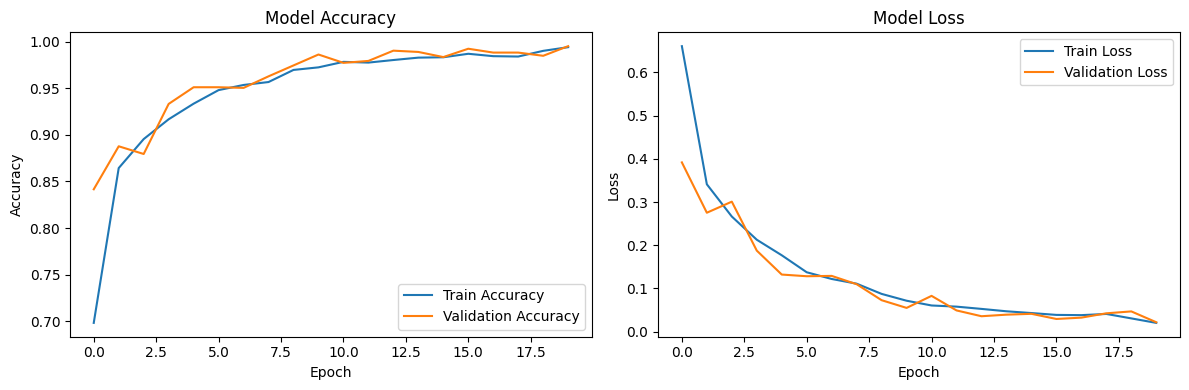

In [ ]:
# Early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Fit the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,  # Number of epochs to train
    batch_size=32,  # Number of samples per gradient update
    validation_data=(X_valid, y_valid),  # Validation data
    callbacks=[early_stopping, reduce_lr],  # Add callbacks for optimization
    verbose=1  # Display progress during training
)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))                                                # Specify the width and height of the graph
plt.subplot(1, 2, 1)                                                       # Create a grid with 1 row and 2 column, for placing the graph || Last digits shows the graph placing in the left side
plt.plot(history.history['accuracy'], label='Train Accuracy')              # Plots the training accuracy inside the graph
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')     # Plots the validation accuracy inside the graph
plt.title('Model Accuracy')                                                # Title of the graph
plt.ylabel('Accuracy')                                                     # y-axis label title
plt.xlabel('Epoch')                                                        # x-axis label title
plt.legend(loc='lower right')                                              # Legends located at the lower right

plt.subplot(1, 2, 2)                                                       # Last parameter, "2" shows that this graph will be placing at the right side
plt.plot(history.history['loss'], label='Train Loss')                      # Plot the result of train loss
plt.plot(history.history['val_loss'], label='Validation Loss')             # Plot the result of validation loss
plt.title('Model Loss')                                                    # Title of the graph
plt.ylabel('Loss')                                                         # y-axis label title
plt.xlabel('Epoch')                                                        # x-axis label title
plt.legend(loc='upper right')                                              # Legends located at upper right

plt.tight_layout()                                                         # Adjust the space between each graph (making the text, line, graph more tidy)
plt.show(block=True)                                                       # Display the graph

# Model Evaluate

In [ ]:
train_loss, train_acc = model.evaluate(train_images, train_labels)
print('Training Accuracy: ', train_acc)
print('Training Loss: ', train_loss)

227/227 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - accuracy: 0.9958 - loss: 0.0158
Training Accuracy:  0.9955910444259644
Training Loss:  0.01679142937064171


In [ ]:
val_loss, val_acc = model.evaluate(valid_images, valid_labels)
print('Validation Accuracy: ', val_acc)
print('Validation Loss: ', val_loss)

46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.9888 - loss: 0.0244
Validation Accuracy:  0.9931082129478455
Validation Loss:  0.019191743806004524


In [ ]:
model.save('Trained_Plant_Diseases_Model.keras')

In [ ]:
history.history

{'accuracy': [0.6982283592224121,
  0.8643701076507568,
  0.8954724669456482,
  0.9167323112487793,
  0.9334645867347717,
  0.948031485080719,
  0.9535433053970337,
  0.9566929340362549,
  0.9696850180625916,
  0.9724409580230713,
  0.9783464670181274,
  0.9775590300559998,
  0.9803149700164795,
  0.9828740358352661,
  0.9832677245140076,
  0.9870078563690186,
  0.9844487905502319,
  0.9840551018714905,
  0.9901574850082397,
  0.9940944910049438],
 'loss': [0.6606852412223816,
  0.3410392105579376,
  0.26641181111335754,
  0.21269668638706207,
  0.17674493789672852,
  0.13741131126880646,
  0.12187840044498444,
  0.11097373813390732,
  0.08733915537595749,
  0.07155140489339828,
  0.06053313612937927,
  0.05785718187689781,
  0.05261843279004097,
  0.047099705785512924,
  0.0430094338953495,
  0.03872760385274887,
  0.03818848729133606,
  0.040932174772024155,
  0.030635662376880646,
  0.020247111096978188],
 'val_accuracy': [0.8415977954864502,
  0.8877410292625427,
  0.87947660684585

# Evaluation Matrix: Accuracy Evaluation



Text(0, 0.5, 'Accuracy')

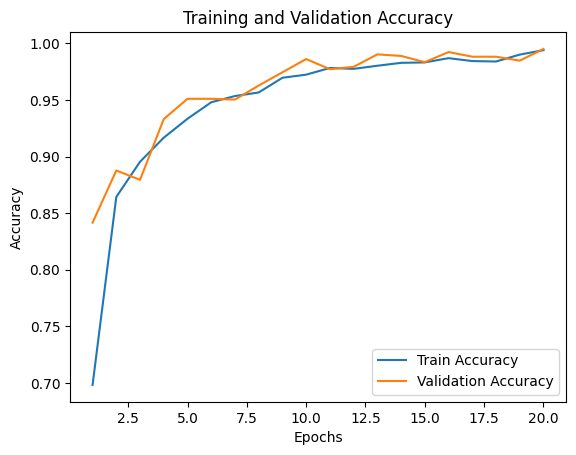

In [ ]:
epochs = [i for i in range(1, 21)]
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Test Directory

In [ ]:
from tensorflow.keras.utils import array_to_img
import shutil

selected_classes = ['Tomato___Early_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

# Create directories for each class
os.makedirs(test_dir, exist_ok=True)
for class_name in selected_classes:
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Iterate over the test dataset and save images in respective class directories
for idx, (image, label) in enumerate(zip(X_test, y_test)):
    class_name = selected_classes[label]  # Determine the class name from the label
    class_dir = os.path.join(test_dir, class_name)  # Directory for the class
    image_path = os.path.join(class_dir, f"image_{idx}.jpg")  # Path to save the image
    array_to_img(image).save(image_path)  # Save the image


test_set = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=selected_classes,  # Specify only the desired classes
    color_mode="rgb",
    batch_size=1,
    image_size=(64, 64),
    shuffle=False,
    interpolation="bilinear",
)

Found 726 files belonging to 3 classes.


# Prediction

In [ ]:
y_pred = model.predict(test_set)
y_pred, y_pred.shape

726/726 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


(array([[1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=float32),
 (726, 3))

In [ ]:
predicted_categories = tf.argmax(y_pred, axis = 1)
predicted_categories

<tf.Tensor: shape=(726,), dtype=int64, numpy=
array([0, 0, 2, 0, 0, 1, 2, 2, 1, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     

In [ ]:
true_categories = tf.concat([y for x,y in test_set], axis = 0)
true_categories

<tf.Tensor: shape=(726, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [ ]:
Y_true = tf.argmax(true_categories, axis = 1)
Y_true

<tf.Tensor: shape=(726,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     

# Evaluation Matrics: Precision, Recalll, F1-Score

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_true, predicted_categories, target_names = selected_classes))

                                        precision    recall  f1-score   support

                 Tomato___Early_blight       0.96      0.76      0.85       250
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.83      0.97      0.90       244
                      Tomato___healthy       0.89      0.94      0.92       232

                              accuracy                           0.89       726
                             macro avg       0.90      0.89      0.89       726
                          weighted avg       0.90      0.89      0.89       726



# Confusion Matrices

In [ ]:
conf_matr = confusion_matrix(Y_true, predicted_categories)
conf_matr

array([[190,  34,  26],
       [  7, 237,   0],
       [  0,  14, 218]])

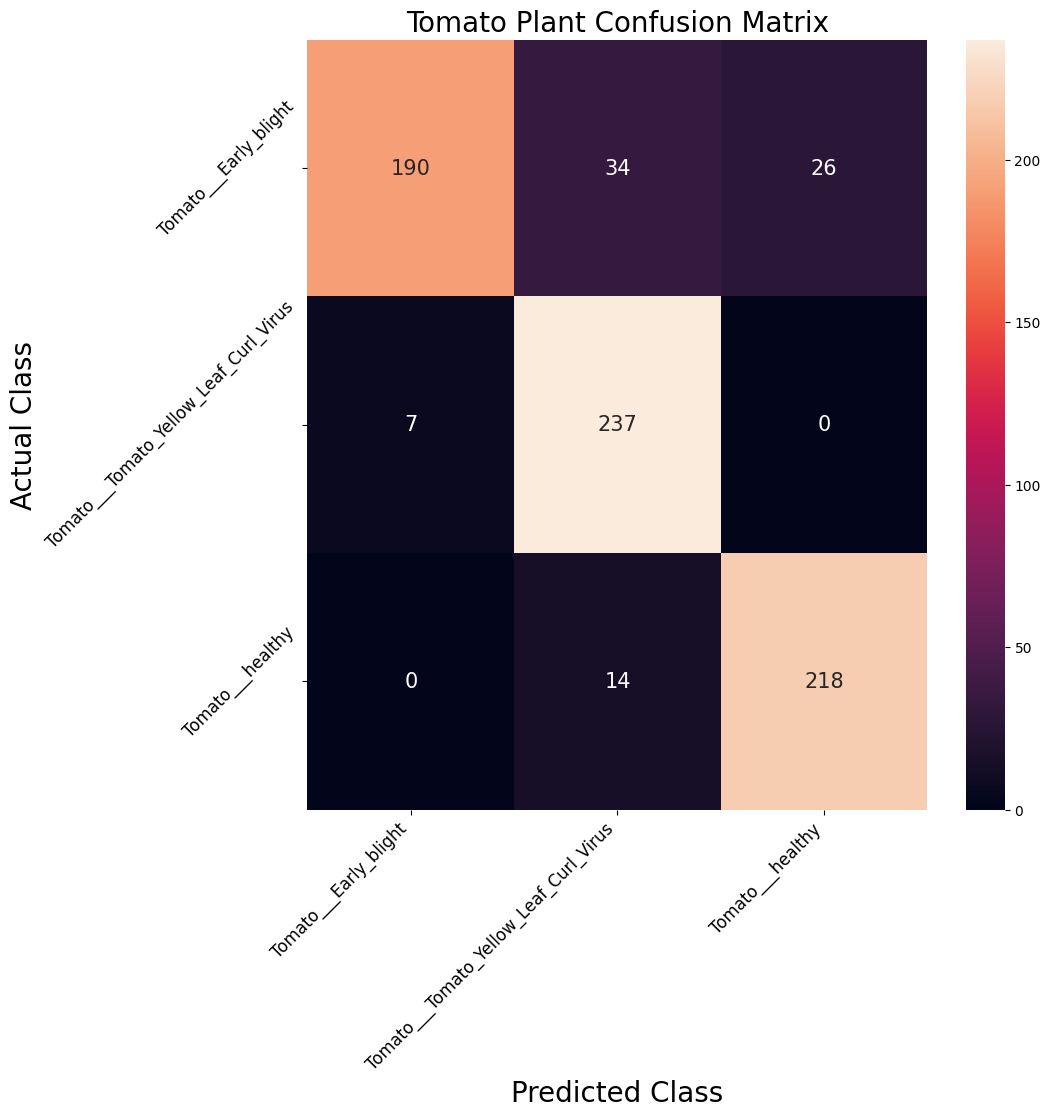

In [ ]:
# Define your class names
class_names = ["Tomato___Early_blight", "Tomato___Tomato_Yellow_Leaf_Curl_Virus", "Tomato___healthy"]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matr, annot=True, fmt="d", annot_kws={'size': 15}, xticklabels=class_names, yticklabels=class_names)

# Set axis labels and title
plt.xlabel("Predicted Class", fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title("Tomato Plant Confusion Matrix", fontsize=20)

# Rotate tick labels for better visibility
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=45, fontsize=12)

# Show the plot
plt.show()
